In [1]:
from glob import glob
import pydicom as dicom
import numpy as np
import os
import matplotlib.pyplot as plt
from point import Point
from vector import Vector
from ray import Ray
from math import sqrt
from tqdm import tqdm
from line import Line

In [5]:
input_dir = 'dataset/patient_A'
series = os.listdir(input_dir)
files = glob(f"{input_dir}/{series[1]}/*.dcm")

data = {}
locations = []
for file in files:
    img = dicom.dcmread(file)
    loc = float(img.SliceLocation)
    locations.append(loc)
    data[loc] = img.pixel_array
slices = []
locations.sort()
for location in locations:
    slices.append(data[location])
img = np.stack(slices)
img = img/img.max()
img = np.transpose(img,[1,2,0])
img = img[::-1,:,::-1]


img[10,10,70] = 1

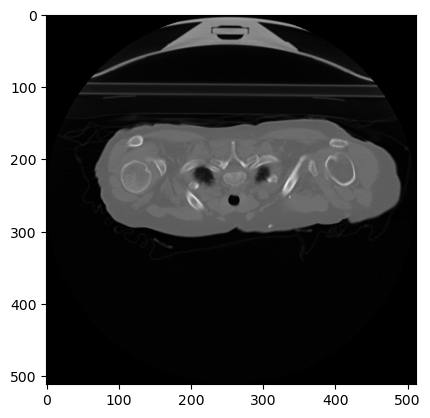

In [6]:
plt.imshow(img[:,:,0],cmap='gray')

# First Working Example (To Slow)

In [ ]:
# Set up the volume
volume_orgin = Vector(0,0,0)
volume = img
volume_corner = volume_orgin - Vector((volume.shape[1]-1)/2, (volume.shape[0]-1)/2, 0) #this is upper left corner

# Set up the Camera
width = max(volume.shape[0], volume.shape[1])
height = volume.shape[2]
# lets calculate the radius of a circle centered on the volume that would fit the volume with some padding
radius = int(sqrt(width*width)/2) + 10
number_of_frames = 25
theta = np.linspace(0, 2 * np.pi, number_of_frames)


frames = []
# Lets generate some frames!
for angle in tqdm(theta):
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    camera = Vector(x,y,0)
    frame = np.zeros((width, height))

    camera_direction = (volume_orgin - camera).normalize() 
    camera_norm = Vector(-camera_direction.y, camera_direction.x, camera_direction.z)
    c_start = camera + camera_norm * (width-1)/2  #this is left side of camera plane
    for i in range(width):
        first_hit = None
        pix_pos = c_start - camera_norm * i
        ray_values = [[] for _ in range(height)]
        for vj in range(volume.shape[0]):
            last_closeness = 100000
            if first_hit is not None:
                if vj < first_hit[1] - 1 or vj > first_hit[1] + 1:
                    continue

            for vi in range(volume.shape[1]):
                vox_pos = volume_corner + Vector(vi, vj, 0)
                pixel_to_vox = pix_pos - vox_pos
                magnitude = camera_direction.dot_product(pixel_to_vox)
                closeness = (pix_pos - magnitude * camera_direction - vox_pos).magnitude()
                if closeness <= 0.5:
                    if first_hit is None:
                        first_hit = (vi,vj)
                    for h in range(height):
                        ray_values[h].append(volume[vj,vi,h])
                else:
                    if closeness > last_closeness:
                        break
                last_closeness = closeness

        if len(ray_values) > 0:
            for j in range(height):
                frame[i,j] = max(ray_values[j])
    frames.append(frame.copy())
    break
# orignal code took 16 minutes to run
# the closeness update and first hit took it down to 8 mins

  0%|          | 0/25 [08:26<?, ?it/s]


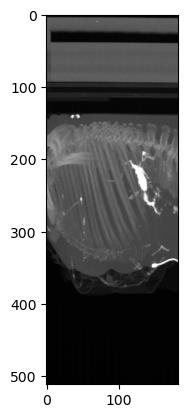

In [103]:
plt.imshow(frame,cmap='gray')

In [100]:
# can we make this faster???
# Yes the closeness check brings us from 144 loops to just 84
# We can also use last hit to skip some going from 84 to 42
v_orgin = Vector(0,0,0)
v = np.array([[0,0,0,0,0,0],
              [0,1,0,1,1,0],
              [0,1,0,1,1,0],
              [0,0,0,0,0,0]])

v_corner = v_orgin - Vector((v.shape[1]-1)/2, (v.shape[0]-1)/2, 0) #this is upper left corner ish
camera = Vector(0,-4,0)

width = 6
camera_direction = (v_orgin - camera).normalize() 
camera_norm = Vector(-camera_direction.y, camera_direction.x, camera_direction.z)
c_start = camera + camera_norm * (width-1)/2  #this is left side of camera plane
image = np.zeros(width)
# first_hit = None
loops = 0
for i in range(width):
    first_hit = None
    pix_pos = c_start - camera_norm * i
    ray_values = []
    for vj in range(v.shape[0]):
        last_closeness = 100
        if first_hit is not None:
            if vj < first_hit[1] - 1 or vj > first_hit[1] + 1:
                continue
        for vi in range(v.shape[1]):
            vox_pos = v_corner + Vector(vi, vj, 0)
            pixel_to_vox = pix_pos - vox_pos
            magnitude = camera_direction.dot_product(pixel_to_vox)
            closeness = (pix_pos - magnitude * camera_direction - vox_pos).magnitude()
            if closeness <= 0.5:
                if first_hit is None:
                    first_hit = (vi,vj)
                ray_values.append(v[vj,vi])
            else:
                if closeness > last_closeness:
                    break
            last_closeness = closeness
            loops += 1
    if len(ray_values) > 0:
        image[i] = max(ray_values)
    else:
        image[i] = 0



In [175]:
# heck yeah this actually works!!! damn girl my brain is bing bonged
v_orgin = Vector(0,0,0)
v = np.array([[0,0,0,0,0,0],
              [0,1,0,1,1,0],
              [0,1,0,1,1,0],
              [0,0,0,0,0,0]])

v_corner = v_orgin - Vector((v.shape[1]-1)/2, (v.shape[0]-1)/2, 0) #this is upper left corner ish
camera = Vector(0,4,0)

width = 6
camera_direction = (v_orgin - camera).normalize() 
camera_norm = Vector(-camera_direction.y, camera_direction.x, camera_direction.z)
c_start = camera + camera_norm * (width-1)/2  #this is left side of camera plane
image = np.zeros(width)
for i in range(width):
    pix_pos = c_start - camera_norm * i
    ray_values = []

    for vj in range(v.shape[0]):
        for vi in range(v.shape[1]):
            vox_pos = v_corner + Vector(vi, vj, 0)
            pixel_to_vox = pix_pos - vox_pos
            magnitude = camera_direction.dot_product(pixel_to_vox)
            closeness = (pix_pos - magnitude * camera_direction - vox_pos).magnitude()
            if closeness <= 0.5:
                ray_values.append(v[vj,vi])
    if len(ray_values) > 0:
        image[i] = max(ray_values)
    else:
        image[i] = 0



In [176]:
image

array([0., 1., 1., 0., 1., 0.])

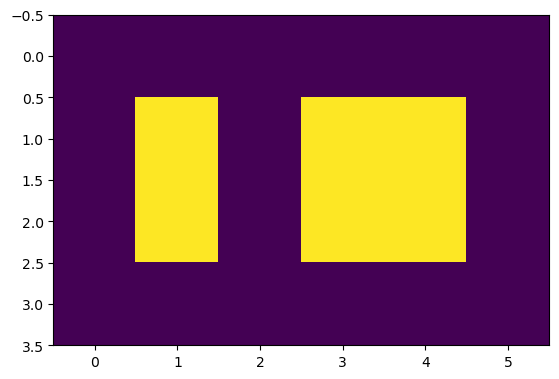

In [240]:
plt.imshow(v)

# Lets be way smarter about our sampling!

In [ ]:
# Basic Idea is to find the corner we are closest too and then use the magnitude and direction
# to find a best guest of our first voxel to check on the edge of the volume.
# Once we find that first voxel we can burrow through the volume using that seed voxel
v_orgin = Vector(0,0,0)
v = np.array([[0,0,0,0,0,0],
              [0,1,0,1,1,0],
              [0,1,0,1,1,0],
              [0,0,0,0,0,0]])
max_ray_length = 100
vc1 = v_orgin - Vector((v.shape[1]-1)/2, (v.shape[0]-1)/2, 0) #upper left corner
vc2 = v_orgin + Vector((v.shape[1]-1)/2, -(v.shape[0]-1)/2, 0) #upper right corner
vc3 = v_orgin + Vector((v.shape[1]-1)/2, (v.shape[0]-1)/2, 0) #lower right corner
vc4 = v_orgin - Vector((v.shape[1]-1)/2, -(v.shape[0]-1)/2, 0) #lower left corner 
corners = [vc1,vc2,vc3,vc4]
corners_index = [(0,0),(0,v.shape[1]-1),(v.shape[0]-1,v.shape[1]-1),(v.shape[0]-1,0)]
camera = Vector(-4,4,0)
width = 6
camera_direction = (v_orgin - camera).normalize() 
camera_norm = Vector(-camera_direction.y, camera_direction.x, camera_direction.z)
c_start = camera + camera_norm * (width-1)/2  #this is left side of camera plane

image = np.zeros(width)
doX = True
doY = True
if camera_direction.x == 0:
    doX = False
if camera_direction.y == 0:
    doY = False
for i in range(width):
    # if i == 0:
    #     continue
    pix_pos = c_start - camera_norm * i
    # pix_pos = Vector(0,5,0)
    pixel_to_corners = [pix_pos-c for c in corners]
    magnitudes = [pv.magnitude() for pv in pixel_to_corners]
    min_magnitude = min(magnitudes)
    min_idx = magnitudes.index(min_magnitude)
    if doX:
        steps_x = (pix_pos.x - corners[min_idx].x) / camera_direction.x
        intersection_x = (pix_pos - steps_x * camera_direction)
    if doY:
        steps_y = (pix_pos.y - corners[min_idx].y) / camera_direction.y
        intersection_y = (pix_pos - steps_y * camera_direction)

    adj_corner = (min_idx+1)%4 #clockwise
    x_coords = [corners[min_idx].x,corners[adj_corner].x]
    y_coords = [corners[min_idx].y,corners[adj_corner].y]
    x_coords.sort()
    y_coords.sort()
    seed = None
    if doX:
        is_between_x = x_coords[0] <= round(intersection_x.x,1) <= x_coords[1] and y_coords[0] <= round(intersection_x.y,1) <= y_coords[1]
        if is_between_x:
            seed = intersection_x
    if doY and seed is None:
        is_between_y = x_coords[0] <= round(intersection_y.x,1) <= x_coords[1] and y_coords[0] <= round(intersection_y.y,1) <= y_coords[1]
        if is_between_y:
            seed = intersection_y

    if seed is None:
        adj_corner = (min_idx-1)%4 #counterclockwise
        x_coords = [corners[min_idx].x,corners[adj_corner].x]
        y_coords = [corners[min_idx].y,corners[adj_corner].y]
        x_coords.sort()
        y_coords.sort()
        if doX:
            is_between_x = x_coords[0] <= round(intersection_x.x,1) <= x_coords[1] and y_coords[0] <= round(intersection_x.y,1) <= y_coords[1]
            if is_between_x:
                seed = intersection_x
        if doY and seed is None:
            is_between_y = x_coords[0] <= round(intersection_y.x,1) <= x_coords[1] and y_coords[0] <= round(intersection_y.y,1) <= y_coords[1]
            if is_between_y:
                seed = intersection_y
    if seed is None:
        image[i] = 0
        continue
    steps_from_corner_y = round(corners[min_idx].x - seed.x)
    steps_from_corner_x = round(corners[min_idx].y - seed.y)
    seed_idx = (int(corners_index[min_idx][0] - steps_from_corner_x),int(corners_index[min_idx][1] - steps_from_corner_y))

    ray_values = []
    mxr = 0
    lx = -1
    ly = -1
  
    while mxr < max_ray_length:
        nx = round(seed_idx[0] + mxr * camera_direction.y)
        ny = round(seed_idx[1] + mxr * camera_direction.x)
        #OMG this stupid variable needs to be higher damn it
        mxr += 1

        if nx < 0 or nx >= v.shape[0] or ny < 0 or ny >= v.shape[1]:
            break

        if nx == lx and ny == ly:
            continue
        vox_pos = corners[0] + (Vector(ny, nx, 0))

        pixel_to_vox = pix_pos - vox_pos
        magnitude = camera_direction.dot_product(pixel_to_vox)
        closeness = (pix_pos - magnitude * camera_direction - vox_pos).magnitude()
        if closeness <= 0.5:
            ray_values.append(v[nx,ny])
        lx = nx
        ly = ny

    if len(ray_values) > 0:
        image[i] = max(ray_values)
    else:
        image[i] = 0
        


    

    # for vj in range(v.shape[0]):
    #     for vi in range(v.shape[1]):
    #         vox_pos = v_corner + Vector(vi, vj, 0)
    #         pixel_to_vox = pix_pos - vox_pos
    #         magnitude = camera_direction.dot_product(pixel_to_vox)
    #         closeness = (pix_pos - magnitude * camera_direction - vox_pos).magnitude()
    #         if closeness <= 0.5:
    #             ray_values.append(v[vj,vi])
    # if len(ray_values) > 0:
    #     image[i] = max(ray_values)



In [16]:
# Set up the volume
max_ray_length = 1000000
volume_orgin = Vector(0,0,0)
volume = img
# volume_corner = volume_orgin - Vector((volume.shape[1]-1)/2, (volume.shape[0]-1)/2, 0) #this is upper left corner
vc1 = v_orgin - Vector((volume.shape[1]-1)/2, (volume.shape[0]-1)/2, 0) #upper left corner
vc2 = v_orgin + Vector((volume.shape[1]-1)/2, -(volume.shape[0]-1)/2, 0) #upper right corner
vc3 = v_orgin + Vector((volume.shape[1]-1)/2, (volume.shape[0]-1)/2, 0) #lower right corner
vc4 = v_orgin - Vector((volume.shape[1]-1)/2, -(volume.shape[0]-1)/2, 0) #lower left corner 
corners = [vc1,vc2,vc3,vc4]
corners_index = [(0,0),(0,volume.shape[1]-1),(volume.shape[0]-1,volume.shape[1]-1),(volume.shape[0]-1,0)]

# Set up the Camera
width = max(volume.shape[0], volume.shape[1])
height = volume.shape[2]
# lets calculate the radius of a circle centered on the volume that would fit the volume with some padding
radius = int(sqrt(width*width)/2) + 10
number_of_frames = 25
theta = np.linspace(0, 2 * np.pi, number_of_frames)


frames = []
# Lets generate some frames!
for angle in tqdm(theta):
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    camera = Vector(x,y,0)
    frame = np.zeros((width, height))

    camera_direction = (volume_orgin - camera).normalize() 
    camera_norm = Vector(-camera_direction.y, camera_direction.x, camera_direction.z)
    c_start = camera + camera_norm * (width-1)/2  #this is left side of camera plane
    doX = True
    doY = True
    if camera_direction.x == 0:
        doX = False
    if camera_direction.y == 0:
        doY = False
    for i in range(width):
        # if i == 0:
        #     continue
        pix_pos = c_start - camera_norm * i
        # pix_pos = Vector(0,5,0)
        pixel_to_corners = [pix_pos-c for c in corners]
        magnitudes = [pv.magnitude() for pv in pixel_to_corners]
        min_magnitude = min(magnitudes)
        min_idx = magnitudes.index(min_magnitude)
        if doX:
            steps_x = (pix_pos.x - corners[min_idx].x) / camera_direction.x
            intersection_x = (pix_pos - steps_x * camera_direction)
        if doY:
            steps_y = (pix_pos.y - corners[min_idx].y) / camera_direction.y
            intersection_y = (pix_pos - steps_y * camera_direction)

        adj_corner = (min_idx+1)%4 #clockwise
        x_coords = [corners[min_idx].x,corners[adj_corner].x]
        y_coords = [corners[min_idx].y,corners[adj_corner].y]
        x_coords.sort()
        y_coords.sort()
        seed = None
        if doX:
            is_between_x = x_coords[0] <= round(intersection_x.x,1) <= x_coords[1] and y_coords[0] <= round(intersection_x.y,1) <= y_coords[1]
            if is_between_x:
                seed = intersection_x
        if doY and seed is None:
            is_between_y = x_coords[0] <= round(intersection_y.x,1) <= x_coords[1] and y_coords[0] <= round(intersection_y.y,1) <= y_coords[1]
            if is_between_y:
                seed = intersection_y

        if seed is None:
            adj_corner = (min_idx-1)%4 #counterclockwise
            x_coords = [corners[min_idx].x,corners[adj_corner].x]
            y_coords = [corners[min_idx].y,corners[adj_corner].y]
            x_coords.sort()
            y_coords.sort()
            if doX:
                is_between_x = x_coords[0] <= round(intersection_x.x,1) <= x_coords[1] and y_coords[0] <= round(intersection_x.y,1) <= y_coords[1]
                if is_between_x:
                    seed = intersection_x
            if doY and seed is None:
                is_between_y = x_coords[0] <= round(intersection_y.x,1) <= x_coords[1] and y_coords[0] <= round(intersection_y.y,1) <= y_coords[1]
                if is_between_y:
                    seed = intersection_y
        if seed is None:
            image[i] = 0
            continue
        steps_from_corner_y = round(corners[min_idx].x - seed.x)
        steps_from_corner_x = round(corners[min_idx].y - seed.y)
        seed_idx = (int(corners_index[min_idx][0] - steps_from_corner_x),int(corners_index[min_idx][1] - steps_from_corner_y))

        mxr = 0
        lx = -1
        ly = -1
        ray_values = [[] for _ in range(height)]
        while mxr < max_ray_length:
            nx = round(seed_idx[0] + mxr * camera_direction.y)
            ny = round(seed_idx[1] + mxr * camera_direction.x)
            #OMG this stupid variable needs to be higher damn it
            mxr += 1

            if nx < 0 or nx >= volume.shape[0] or ny < 0 or ny >= volume.shape[1]:
                break

            if nx == lx and ny == ly:
                continue
            vox_pos = corners[0] + (Vector(ny, nx, 0))

            pixel_to_vox = pix_pos - vox_pos
            magnitude = camera_direction.dot_product(pixel_to_vox)
            closeness = (pix_pos - magnitude * camera_direction - vox_pos).magnitude()
            if closeness <= 0.5:
                for h in range(height):
                    ray_values[h].append(volume[nx,ny,h])
            lx = nx
            ly = ny

        for j in range(height):
            if len(ray_values[j]) > 0:
                frame[i,j] = max(ray_values[j])





    # for i in range(width):
    #     first_hit = None
    #     pix_pos = c_start - camera_norm * i
    #     ray_values = [[] for _ in range(height)]
    #     for vj in range(volume.shape[0]):
    #         last_closeness = 100000
    #         if first_hit is not None:
    #             if vj < first_hit[1] - 1 or vj > first_hit[1] + 1:
    #                 continue

    #         for vi in range(volume.shape[1]):
    #             vox_pos = volume_corner + Vector(vi, vj, 0)
    #             pixel_to_vox = pix_pos - vox_pos
    #             magnitude = camera_direction.dot_product(pixel_to_vox)
    #             closeness = (pix_pos - magnitude * camera_direction - vox_pos).magnitude()
    #             if closeness <= 0.5:
    #                 if first_hit is None:
    #                     first_hit = (vi,vj)
    #                 for h in range(height):
    #                     ray_values[h].append(volume[vj,vi,h])
    #             else:
    #                 if closeness > last_closeness:
    #                     break
    #             last_closeness = closeness

    #     if len(ray_values) > 0:
    #         for j in range(height):
    #             frame[i,j] = max(ray_values[j])
    frames.append(frame.copy())

# orignal code took 16 minutes to run
# the closeness update and first hit took it down to 8 mins
# the final one took 11 seconds

100%|██████████| 25/25 [03:33<00:00,  8.56s/it]


In [22]:
imgs = [frame*255 for frame in frames]
imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=150, loop=0)

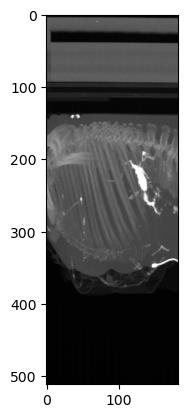

In [15]:
plt.imshow(frame,cmap='gray')

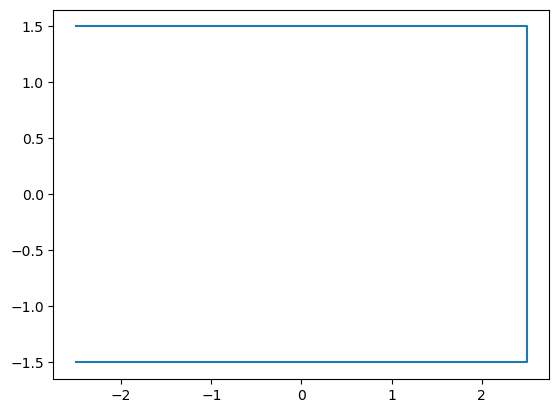

In [110]:
plt.plot(x,y)

In [ ]:


v_orgin = Vector(0,0,0)
v = np.array([[0,0,0,0,0,0],
              [0,1,0,1,1,0],
              [0,1,0,1,1,0],
              [0,0,0,0,0,0]])

vc1 = v_orgin - Vector((v.shape[1]-1)/2, (v.shape[0]-1)/2, 0)
vc2 = v_orgin + Vector((v.shape[1]-1)/2, (v.shape[0]-1)/2, 0)
vc3 = v_orgin - Vector((v.shape[1]-1)/2, (v.shape[0]-1)/2, 0)
vc4 = v_orgin - Vector((v.shape[1]-1)/2, (v.shape[0]-1)/2, 0)



v_corner = v_orgin - Vector((v.shape[1]-1)/2, (v.shape[0]-1)/2, 0) #this is upper left corner ish
camera = Vector(0,4,0)

width = 6
camera_direction = (v_orgin - camera).normalize() 
camera_norm = Vector(-camera_direction.y, camera_direction.x, camera_direction.z)
c_start = camera + camera_norm * (width-1)/2  #this is left side of camera plane
image = np.zeros(width)
for i in range(width):
    pix_pos = c_start - camera_norm * i
    ray_values = []

    for vj in range(v.shape[0]):
        for vi in range(v.shape[1]):
            vox_pos = v_corner + Vector(vi, vj, 0)
            pixel_to_vox = pix_pos - vox_pos
            magnitude = camera_direction.dot_product(pixel_to_vox)
            closeness = (pix_pos - magnitude * camera_direction - vox_pos).magnitude()
            if closeness <= 0.5:
                ray_values.append(v[vj,vi])
    if len(ray_values) > 0:
        image[i] = max(ray_values)
    else:
        image[i] = 0



In [ ]:
# This is garbage and does not work hehe
v_orgin = Vector(0,0,0)
v = np.array([[0,0,0,0,0,0],
              [0,1,0,1,1,0],
              [0,1,0,1,1,0],
              [0,0,0,0,0,0]])
# vx_offset = 0.5 - (v.shape[0] % 2) * 0.5
# vy_offset = 0.5 - (v.shape[0] % 2) * 0.5
v_corner = v_orgin - Vector((v.shape[1]-1)/2, (v.shape[0]-1)/2, 0) #this is bottom left corner ish
camera = Vector(-2,-4,0)

width = 6
camera_direction = (camera - v_orgin).normalize()
camera_norm = Vector(camera_direction.y, camera_direction.x, camera_direction.z).normalize()
c_start = camera + camera_norm * (width-1)/2  #this is left side of camera plane
image = np.zeros(width)
for i in range(width):
    pix_pos = c_start - camera_norm * i
    ray_values = []
    for vj in range(v.shape[0]):
        for vi in range(v.shape[1]):
            vox_pos = v_corner + Vector(vi, vj, 0)
            pixel_to_vox = pix_pos - vox_pos
            magnitude = camera_direction.dot_product(pixel_to_vox)
            closeness = (pix_pos - magnitude * camera_direction - vox_pos).magnitude()
            if closeness <= 0.5:
                ray_values.append(v[vj,vi])
            break
        break
    break
    # image[i] = max(ray_values)



In [91]:
print(camera_direction)

(-0.4472135954999579, -0.8944271909999159, 0.0)


In [93]:
print(v_orgin -camera)

(2, 4, 0)


In [126]:
image

array([0., 1., 1., 0., 1., 0.])

In [113]:
print(camera_norm)

(0.8944271909999159, -0.4472135954999579, 0.0)


In [109]:
print(camera_direction)

(0.4472135954999579, 0.8944271909999159, 0.0)
